**Setup:**
Import all libraries, set basic config (dates, paths, random seed), and define the ETF universe and successor map for old tickers.

In [ ]:
!pip install xgboost lightgbm

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import joblib
import os
import pickle
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.covariance import LedoitWolf
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Quiet down some LightGBM feature-name warnings that clutter the log
warnings.filterwarnings("ignore", message="X does not have valid feature names")



# Date ranges for training vs backtest
PRICE_START    = "2012-01-01"
TRAIN_END_DATE = "2020-12-31"   # ML only sees data up to this date
BACKTEST_START = "2021-01-01"
BACKTEST_END   = "2024-12-31"

# General backtest / risk model settings
LOOKBACK_DAYS  = 252            # how many days of history to estimate μ, Σ
REBALANCE_DAYS = 63             # roughly quarterly rebalancing (in trading days)
MAX_WEIGHT     = 0.05           # hard cap per asset
TOP_K          = 75             # max number of names ML is allowed to pick

RANDOM_SEED    = 42

# Input / output paths (expect these folders to exist or be created)
SP500_HISTORY_CSV = "resources/s&p500_history.csv"   # point-in-time membership

OUT_DATA_DIR     = "resources/data"
OUT_MODELS_DIR   = "resources/models"
OUT_RESULTS_DIR  = "resources/results"

os.makedirs(OUT_DATA_DIR, exist_ok=True)
os.makedirs(OUT_MODELS_DIR, exist_ok=True)
os.makedirs(OUT_RESULTS_DIR, exist_ok=True)

np.random.seed(RANDOM_SEED)

# Extra ETFs added on top of S&P names to give the optimizer more tools
ETF_TICKERS = [
    # Sector ETFs
    'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP',
    'XLRE', 'XLU', 'XLY', 'XLC', 'XLV',

    # Factor / Style ETFs
    'SPLV', 'MTUM', 'QUAL', 'VLUE', 'IWM', 'VTV',

    # Broad Market ETFs
    'SPY', 'QQQ', 'DIA', 'VT', 'VTI',

    # International / EM
    'EFA', 'VWO', 'EWJ', 'EWU', 'EWC',

    # Bonds
    'TLT', 'IEF', 'SHY', 'HYG', 'LQD',

    # Commodities / Alternatives
    'GLD', 'SLV', 'DBC', 'USO', 'UUP',

    # Volatility
    'VIXY'
]


# Map delisted tickers to their modern replacements when possible.
# If the list is empty, we basically drop that old name.
SUCCESSOR_MAP = {
    # Well-known acquisitions / mergers
    "WFM":  ["AMZN"],
    "TWC":  ["CMCSA"],
    "COV":  ["MDT"],
    "LVLT": ["LUMN"],
    "CELG": ["BMY"],
    "STJ":  ["ABT"],
    "BXLT": ["TAK"],
    "KRFT": ["KHC"],
    "HNZ":  ["KHC"],
    "PCP":  ["BRK-B"],
    "DTV":  ["T"],
    "SYMC": ["GEN"],
    "RAI":  ["BTI"],
    "BRCM": ["AVGO"],
    "CVC":  ["CHTR"],
    "GAS":  ["SO"],
    "LLTC": ["ADI"],
    "ARG":  ["APD"],
    "SIAL": ["DHR"],
    "NYX":  ["ICE"],
    "FDO":  ["DLTR"],
    "JOY":  ["CAT"],
    "CVH":  ["AET"],
    "PGN":  ["DUK"],
    "APC":  ["OXY"],
    "PXD":  ["XOM"],
    "TWTR": ["X"],
    "FB":   ["META"],
    "MXIM": ["ADI"],
    "ALTR": ["INTC"],
    "BCR":  ["BDX"],
    "CFN":  ["BDX"],
    "GGP":  ["BAM"],
    "WLTW": ["WTW"],
    "HCBK": ["MTB"],
    "PBCT": ["MTB"],
    "WCG":  ["CNC"],
    "MON":  ["BAYRY"],
    "DISCK":["WBD"],
    "DISCA":["WBD"],
    "VIAB": ["PARA"],
    "CBS":  ["PARA"],
    "PARA": ["PARA"],
    "HRS":  ["LHX"],
    "RTN":  ["RTX"],
    "UTX":  ["RTX"],
    "ABMD": ["MDT"],
    "ALXN": ["AZN"],
    "DWDP": ["DOW"],
    "XLNX": ["AMD"],
    "AGN":  ["ABBV"],
    "TIF":  ["MC.PA"],
    "FRX":  ["AGN"],
    "LO":   ["RAI"],
    "GMCR": ["KDP"],

    # Explicit drops (old / OTC / bankrupt)
    "APOL": [],
    "SPLS": [],
    "JCP":  [],
    "DF":   [],
    "CHK":  [],
    "MNK":  [],
    "DNR":  [],
}


**S&P 500 membership helpers:**
Load the point-in-time S&P 500 membership, apply the successor mapping, and build a universe between two dates (plus the ETF tickers).

In [3]:
def load_sp500_history(path_csv):
    """
    Load the SP500 history CSV.
    The file should have: ['date', 'tickers'] where 'tickers' is a comma-separated list.
    """
    sp = pd.read_csv(path_csv)
    sp["date"] = pd.to_datetime(sp["date"])
    sp = sp.sort_values("date").reset_index(drop=True)
    return sp

def normalize_sp500_with_successors(sp_df, mapping):
    """
    Apply the successor map:
    - replace old tickers with new ones where possible
    - drop tickers explicitly mapped to []
    - remove duplicates on each date
    """
    sp = sp_df.copy()

    def map_row(ticker_str):
        tickers = [t.strip() for t in ticker_str.split(",") if t.strip()]
        mapped = []
        for t in tickers:
            if t in mapping and mapping[t]:
                mapped.append(mapping[t][0])  # use the first mapped symbol
            elif t in mapping and not mapping[t]:
                # this one is meant to be dropped completely
                continue
            else:
                mapped.append(t)
        mapped = sorted(set(mapped))
        return ",".join(mapped)

    sp["tickers"] = sp["tickers"].apply(map_row)
    return sp

def get_sp500_members_on(date, sp_df):
    """
    Get the S&P 500 members as of a given date (point-in-time).
    """
    rows = sp_df[sp_df["date"] <= date]
    if rows.empty:
        return []
    last_row = rows.iloc[-1]
    tickers = [t.strip() for t in last_row["tickers"].split(",") if t.strip()]
    return tickers

# Load and normalize the S&P history
sp500_df_raw = load_sp500_history(SP500_HISTORY_CSV)
sp500_df = normalize_sp500_with_successors(sp500_df_raw, SUCCESSOR_MAP)

# Save normalized PIT file so we can re-use it later if needed
sp500_df.to_csv(os.path.join(OUT_DATA_DIR, "sp500_history_normalized.csv"), index=False)

def build_universe_from_sp500(sp_df, start_date, end_date, extra_tickers=None):
    """
    Build the full trading universe across a date range,
    optionally adding extra tickers (like ETFs).
    """
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)

    sub = sp_df[(sp_df["date"] >= start_date) & (sp_df["date"] <= end_date)]
    all_tickers = set()
    for row in sub["tickers"]:
        all_tickers |= set(t.strip() for t in row.split(",") if t.strip())

    if extra_tickers:
        all_tickers |= set(extra_tickers)

    return sorted(all_tickers)


**Download prices from Yahoo Finance:**
Build the full universe, pull daily close prices from yfinance, fix odd tickers like BRK.B → BRK-B, and store the final price matrix to disk.

In [4]:
def download_prices_yf(tickers, start_date, end_date):
    """
    Download adjusted close prices from Yahoo Finance for all tickers.
    """
    print(f"Downloading prices for {len(tickers)} tickers...")
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    if isinstance(data, pd.Series):  # handle single-ticker edge case
        data = data.to_frame()
    data = data.sort_index()
    print("Raw price shape:", data.shape)
    return data

# Build the combined universe (S&P + ETFs)
universe_all = build_universe_from_sp500(
    sp500_df,
    PRICE_START,
    BACKTEST_END,
    extra_tickers=ETF_TICKERS
)

prices_raw = download_prices_yf(universe_all, PRICE_START, BACKTEST_END)

# Small helper: try switching BRK.B-style tickers to BRK-B, etc. if the dot version is all NaN
def fix_ticker_formatting(df):
    fixed = {}
    for t in df.columns:
        if df[t].isna().all() and "." in t:
            alt = t.replace(".", "-")
            try:
                test = yf.download(alt, start=PRICE_START, end=BACKTEST_END)["Close"]
                if not test.isna().all():
                    fixed[t] = alt
            except Exception:
                pass
    return fixed

fmt_map = fix_ticker_formatting(prices_raw)
for old, new in fmt_map.items():
    print(f"[FORMAT FIX] {old} → {new}")
    prices_raw[new] = prices_raw[old]
    del prices_raw[old]

# Drop columns that never had any prices
prices = prices_raw.dropna(axis=1, how="all")
print("Final price DataFrame shape:", prices.shape)

# Save cleaned prices for reuse
prices.to_pickle(os.path.join(OUT_DATA_DIR, "prices.pkl"))


/tmp/ipython-input-581828918.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  764 of 764 completed
ERROR:yfinance:
98 Failed downloads:
ERROR:yfinance:['BRK.B', 'LM', 'AABA', 'AVP', 'ATVI', 'WYND', 'CERN', 'WRK', 'GPS', 'JEC', 'ANSS', 'WIN', 'XL', 'ARNC', 'SWN', 'PARA', 'WBA', 'COG', 'DISH', 'BLL', 'RDC', 'NLSN', 'AGN', 'HFC', 'CDAY', 'ABC', 'JWN', 'PLL', 'KSU', 'MRO', 'ADS', 'RRD', 'PKI', 'CTL', 'VAR', 'LIFE', 'NLOK', 'LSI', 'ETFC', 'ESV', 'CXO', 'PEAK', 'BIG', 'HES', 'FRC', 'FL', 'FLIR', 'LLL', 'PDCO', 'FTR', 'BHGE', 'DNB', 'QEP', 'TSS', 'SIVB', 'IGT', 'ANTM', 'RE', 'RHT', 'CTXS', 'TMK', 'FBHS', 'DFS', 'X', 'CTLT', 'FLT', 'MYL', 'DRE', 'HCP', 'NBL', 'VIAC', 'WPX', 'JNPR', 'ENDP', 'XEC', 'DO', 'FII']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['BF.B', 'CMCSK', 'CPGX', 'PETM', 'NVLS', 'HSP', 'KORS', '

Raw price shape: (3358, 764)


/tmp/ipython-input-581828918.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test = yf.download(alt, start=PRICE_START, end=BACKTEST_END)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-581828918.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test = yf.download(alt, start=PRICE_START, end=BACKTEST_END)["Close"]
[*********************100%***********************]  1 of 1 completed

Final price DataFrame shape: (3358, 666)


**Build ML features:**
Turn prices into per-ticker features (returns, volatility, momentum) and a cross-sectional z-scored target, then split into train vs test by date.

In [5]:
def engineer_features(prices, horizon=21):
    """
    Create basic technical features per ticker and a cross-sectional target.
    - Features: short/medium returns, 10d moving-average deviation, 10d vol, 20d momentum.
    - Target: sum of log returns over the next `horizon` days, z-scored cross-sectionally by date.
    """
    prices_sorted = prices.copy().sort_index()
    log_ret = np.log(prices_sorted / prices_sorted.shift(1))

    records = []

    for t in prices_sorted.columns:
        s_price = prices_sorted[t]
        s_log   = log_ret[t]

        df_t = pd.DataFrame(index=prices_sorted.index)
        df_t["ticker"]       = t
        df_t["log_ret_1d"]   = s_log
        df_t["log_ret_5d"]   = s_log.rolling(5).sum()
        df_t["ma_10d_dev"]   = s_price.rolling(10).mean() / s_price - 1
        df_t["vol_10d"]      = s_log.rolling(10).std()
        df_t["mom_20d"]      = s_price.pct_change(20, fill_method=None)

        # Future `horizon`-day log return
        df_t["target_raw"] = s_log.shift(-horizon).rolling(horizon).sum()

        records.append(df_t)

    feats = pd.concat(records)
    feats.index.name = "date"
    feats = feats.dropna(subset=["target_raw",
                                 "log_ret_1d",
                                 "log_ret_5d",
                                 "ma_10d_dev",
                                 "vol_10d",
                                 "mom_20d"])

    # Cross-sectional z-score per date
    def cs_z(x):
        mu = x.mean()
        sd = x.std(ddof=0)
        return (x - mu) / (sd + 1e-8)

    feats["target"] = feats.groupby("date")["target_raw"].transform(cs_z)
    feats = feats.drop(columns=["target_raw"])
    feats = feats.dropna(subset=["target"])

    print("Feature matrix shape:", feats.shape)
    return feats

features_all = engineer_features(prices, horizon=21)
features_all.to_pickle(os.path.join(OUT_DATA_DIR, "features_all.pkl"))

# Train / backtest split by date (so we don't leak post-2020 info)
features_train = features_all[features_all.index <= TRAIN_END_DATE]
features_test  = features_all[features_all.index > TRAIN_END_DATE]

X_train = features_train.drop(columns=["target"])
y_train = features_train["target"]


Feature matrix shape: (600979, 7)


**Define ML models and pick the best one:**
Set up Ridge, XGBoost, and LightGBM pipelines with shared preprocessing, do a time-based validation split, pick the lowest-MSE model, and save it.

In [6]:
def build_ml_models():
    """
    Build three ML models (Ridge, XGBoost, LightGBM) that all share the same preprocessing:
    - one-hot ticker
    - standardize numeric features
    """
    categorical = ["ticker"]
    numeric = ["log_ret_1d", "log_ret_5d", "ma_10d_dev", "vol_10d", "mom_20d"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
            ("num", StandardScaler(), numeric),
        ]
    )

    # 1) Ridge baseline
    ridge = Pipeline([
        ("prep", preprocessor),
        ("model", Ridge(alpha=1.0))
    ])

    # 2) XGBoost
    xgb = Pipeline([
        ("prep", preprocessor),
        ("model", XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            n_jobs=-1,
            reg_lambda=1.0,
            random_state=RANDOM_SEED
        ))
    ])

    # 3) LightGBM
    lgbm = Pipeline([
        ("prep", preprocessor),
        ("model", LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="regression",
            random_state=RANDOM_SEED
        ))
    ])

    models = {
        "ridge": ridge,
        "xgb": xgb,
        "lgbm": lgbm
    }

    return models

def train_and_select_model(X_train, y_train, features_all, train_end_date, val_frac=0.2):
    """
    Train all models and choose the best one by validation MSE.
    Validation split is done chronologically within the training window.
    """
    feats_train = features_all[features_all.index <= train_end_date]
    n = len(feats_train)
    cutoff = int((1 - val_frac) * n)
    feats_train_sub = feats_train.iloc[:cutoff]
    feats_val_sub   = feats_train.iloc[cutoff:]

    X_train_sub = feats_train_sub.drop(columns=["target"])
    y_train_sub = feats_train_sub["target"]
    X_val_sub   = feats_val_sub.drop(columns=["target"])
    y_val_sub   = feats_val_sub["target"]

    print(f"Train subset: {len(X_train_sub):,} rows, Val subset: {len(X_val_sub):,} rows")

    models = build_ml_models()
    val_mse = {}

    for name, model in models.items():
        print(f"\nFitting {name} model...")
        model.fit(X_train_sub, y_train_sub)
        preds = model.predict(X_val_sub)
        mse = mean_squared_error(y_val_sub, preds)
        val_mse[name] = mse
        print(f"{name} validation MSE: {mse:.6f}")

    best_name = min(val_mse, key=val_mse.get)
    best_model = models[best_name]
    print("\nSelected best model:", best_name, "with MSE =", val_mse[best_name])

    print(f"Refitting best model '{best_name}' on full training data...")
    best_model.fit(X_train, y_train)

    # Save chosen model, plus all candidates and the validation scores
    joblib.dump(best_model, os.path.join(OUT_MODELS_DIR, "best_ml_model.joblib"))
    joblib.dump(models,      os.path.join(OUT_MODELS_DIR, "all_ml_models.joblib"))
    pd.Series(val_mse).to_csv(os.path.join(OUT_RESULTS_DIR, "ml_model_validation_mse.csv"))

    return best_model, val_mse

print("Fitting ML models and selecting best...")
best_ml_model, val_mse = train_and_select_model(
    X_train, y_train, features_all, TRAIN_END_DATE
)
print("Done. Best model saved.")

# Reload from disk once just to prove the save/load works
best_ml_model = joblib.load(os.path.join(OUT_MODELS_DIR, "best_ml_model.joblib"))
print("Loaded best_ml_model from disk.")


Fitting ML models and selecting best...
Train subset: 327,540 rows, Val subset: 81,885 rows

Fitting ridge model...
ridge validation MSE: 1.139550

Fitting xgb model...
xgb validation MSE: 1.188460

Fitting lgbm model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 327540, number of used features: 519
[LightGBM] [Info] Start training from score 0.001971
lgbm validation MSE: 1.124578

Selected best model: lgbm with MSE = 1.1245777016645229
Refitting best model 'lgbm' on full training data...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data po

**Risk model & Monte Carlo helpers:**
Build covariance matrices (with shrinkage + PSD fix), solve mean-variance optimization, and define Monte Carlo simulation + some plotting helpers.

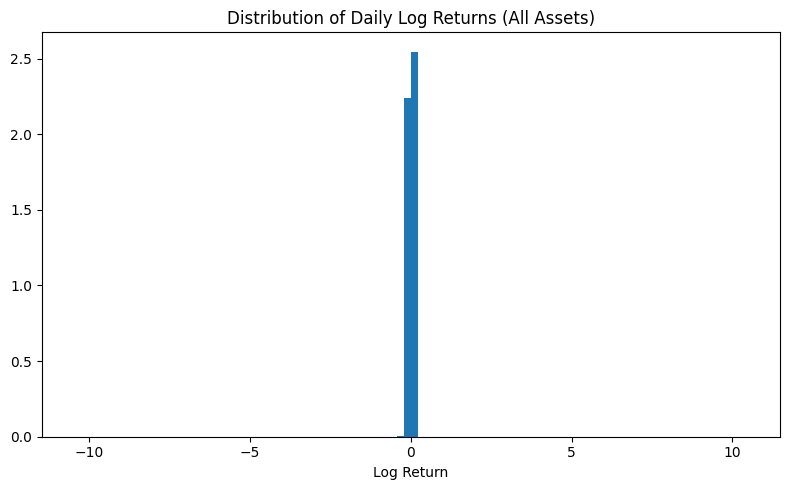

Saved daily log-return distribution to resources/results/dist_daily_log_returns.pdf


In [7]:
def make_psd(matrix, eps=1e-6):
    """
    Make a covariance matrix numerically safe (symmetric PSD) by clipping
    small/negative eigenvalues up to `eps`.
    """
    sym = 0.5 * (matrix + matrix.T)
    vals, vecs = np.linalg.eigh(sym)
    vals_clipped = np.clip(vals, eps, None)
    psd = vecs @ np.diag(vals_clipped) @ vecs.T
    return psd

def compute_mu_cov_for_universe(prices, active_tickers, reb_date, lookback_days=252):
    """
    Estimate μ and Σ for a given universe using the last `lookback_days`.
    Uses Ledoit-Wolf shrinkage, then fixes the covariance to be PSD.
    """
    px = prices[active_tickers].loc[:reb_date]
    px_window = px.tail(lookback_days)

    log_ret = np.log(px_window / px_window.shift(1)).dropna()
    log_ret = log_ret.dropna(axis=1, how="any")

    if log_ret.shape[0] < 10 or log_ret.shape[1] < 5:
        return None, None, []

    mu = log_ret.mean().values

    lw = LedoitWolf().fit(log_ret.values)
    cov = lw.covariance_
    cov_psd = make_psd(cov)

    tickers_final = log_ret.columns.tolist()
    return mu, cov_psd, tickers_final

def mean_variance_opt_full(mu, cov, max_weight=0.05, risk_aversion=1.0):
    """
    Classic mean-variance problem:
        max_w  μᵀw - λ wᵀΣw
        s.t.   sum(w) = 1,  0 <= w <= max_weight
    """
    mu = np.array(mu).ravel()
    cov = np.array(cov)

    n = len(mu)
    w = cp.Variable(n)

    cov_psd = make_psd(cov)
    cov_psd = cp.psd_wrap(cov_psd)   # tells CVXPY the matrix is PSD

    objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, cov_psd))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= max_weight
    ]

    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.SCS, verbose=False)
    except Exception as e:
        print("Optimizer error:", e)
        return np.ones(n) / n

    if w.value is None:
        return np.ones(n) / n

    w_val = np.array(w.value).ravel()
    w_val = np.clip(w_val, 0, None)
    if w_val.sum() == 0:
        w_val = np.ones(n) / n
    else:
        w_val /= w_val.sum()
    return w_val

def monte_carlo_sim(mu, cov, weights, horizon=21, n_sims=10000):
    """
    Run a simple multivariate normal Monte Carlo on log returns.
    Returns an array of final cumulative returns (one per simulation).
    """
    mu = np.asarray(mu)
    cov = np.asarray(cov)
    weights = np.asarray(weights)

    try:
        sims = np.random.multivariate_normal(mu, cov, size=(n_sims, horizon))
    except np.linalg.LinAlgError:
        # If the covariance is still cranky, fall back to a diagonal version
        diag_cov = np.diag(np.diag(cov))
        sims = np.random.multivariate_normal(mu, diag_cov, size=(n_sims, horizon))

    port_daily = sims @ weights
    port_prices = np.exp(np.cumsum(port_daily, axis=1))
    final_returns = port_prices[:, -1] - 1
    return final_returns


def plot_return_distribution(prices, out_dir):
    """
    Quick sanity check: show the distribution of daily log returns across all assets.
    """
    log_ret = np.log(prices / prices.shift(1)).stack().dropna()
    plt.figure(figsize=(8, 5))
    plt.hist(log_ret, bins=100, density=True)
    plt.title("Distribution of Daily Log Returns (All Assets)")
    plt.xlabel("Log Return")
    plt.tight_layout()
    fname = os.path.join(out_dir, "dist_daily_log_returns.pdf")
    plt.savefig(fname)
    plt.show()
    print("Saved daily log-return distribution to", fname)

def plot_mc_sample(mc_returns, out_dir, tag):
    """
    Plot a histogram of Monte Carlo final returns for one rebalance date.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(mc_returns, bins=100, density=True)
    plt.title(f"Sample Monte Carlo Final Return Distribution ({tag})")
    plt.tight_layout()
    fname = os.path.join(out_dir, f"sample_mc_distribution_{tag}.pdf")
    plt.savefig(fname)
    plt.show()
    print("Saved sample MC distribution to", fname)

def plot_mc_paths(mu, cov, w, out_dir, tag, n_paths=25, horizon=63):
    """
    Plot a small set of simulated paths to get a feel for path dispersion.
    """
    try:
        sims = np.random.multivariate_normal(mu, cov, size=(n_paths, horizon))
    except np.linalg.LinAlgError:
        diag_cov = np.diag(np.diag(cov))
        sims = np.random.multivariate_normal(mu, diag_cov, size=(n_paths, horizon))

    port = np.exp(np.cumsum(sims @ w, axis=1))
    plt.figure(figsize=(10, 6))
    plt.plot(port.T, alpha=0.5)
    plt.title(f"Monte Carlo Price Paths (Sample, {tag})")
    plt.tight_layout()
    fname = os.path.join(out_dir, f"mc_paths_{tag}.pdf")
    plt.savefig(fname)
    plt.show()
    print("Saved sample MC paths to", fname)

# One-time global return distribution plot
plot_return_distribution(prices, OUT_RESULTS_DIR)


**Weight snapshot utilities:**
Helper functions to compress the per-day weights into rebalance snapshots and plot the top holdings over time and at the final rebalance.

In [8]:
def compress_weights_to_rebalances(weights_hist, tol=1e-10):
    """
    Take the full weight history (list of (date, weight_series)) and
    keep only dates where the weight vector actually changes.
    This makes it easier to plot rebalance-level holdings.
    """
    if not weights_hist:
        return pd.DataFrame()

    all_tickers = sorted({t for _, w in weights_hist for t in w.index})
    snaps = []
    prev_vec = None

    for d, w_ser in weights_hist:
        w_full = w_ser.reindex(all_tickers).fillna(0)
        vec = w_full.values

        if prev_vec is None or not np.allclose(prev_vec, vec, atol=tol):
            snaps.append((d, w_full))
            prev_vec = vec.copy()

    if not snaps:
        return pd.DataFrame()

    W = pd.DataFrame({d: w for d, w in snaps}).T
    W.index.name = "date"
    W = W.sort_index()
    return W

def plot_top_holdings(weights_hist, name, out_dir, top_n=15):
    """
    Show the top-N tickers (by average weight) as a stacked area chart
    over rebalance dates.
    """
    W = compress_weights_to_rebalances(weights_hist)
    if W.empty:
        print(f"[WARN] No weight snapshots for {name}")
        return

    avg_w = W.mean().sort_values(ascending=False)
    top_tickers = avg_w.head(top_n).index
    W_top = W[top_tickers]

    row_sums = W_top.sum(axis=1).replace(0, np.nan)
    W_norm = W_top.div(row_sums, axis=0)

    plt.figure(figsize=(12, 6))
    W_norm.plot.area(ax=plt.gca(), linewidth=0)
    plt.title(f"{name}: Top {top_n} Holdings Over Rebalance Dates (weight share)")
    plt.ylabel("Weight Share")
    plt.xlabel("Date")
    plt.legend(loc="upper left", fontsize=8, ncol=3)
    plt.tight_layout()
    fname = os.path.join(out_dir, f"{name}_top{top_n}_holdings_area.pdf")
    plt.savefig(fname)
    plt.show()
    print(f"Saved holdings area chart to {fname}")

def plot_final_weights(weights_hist, name, out_dir, top_n=20):
    """
    Bar chart of the final rebalance's top-N holdings.
    """
    W = compress_weights_to_rebalances(weights_hist)
    if W.empty:
        print(f"[WARN] No weight snapshots for {name}")
        return

    w_last = W.iloc[-1].sort_values(ascending=False)
    w_top = w_last.head(top_n)

    plt.figure(figsize=(10, 5))
    w_top.plot(kind="bar")
    plt.title(f"{name}: Final Rebalance Weights (Top {top_n})")
    plt.ylabel("Weight")
    plt.tight_layout()
    fname = os.path.join(out_dir, f"{name}_final_weights_top{top_n}.pdf")
    plt.savefig(fname)
    plt.show()
    print(f"Saved final weights bar chart to {fname}")


**Backtest engines:**
Three backtest functions:
Equal-weight portfolio,
historical mean-variance,
mean-variance blended with ML scores.
All of them also run Monte Carlo at each rebalance.

In [9]:
def backtest_equal_weight(prices,
                          sp500_df,
                          start_date, end_date,
                          lookback_days=LOOKBACK_DAYS):

    prices_bt = prices.loc[start_date:end_date]
    dates = prices_bt.index

    capital = 1.0
    vals = []
    weights_hist = []
    mc_history = []

    i = 0
    first_mc_plotted = False
    print("Running equal weight backtest")
    while i < len(dates):
        reb_date = dates[i]

        sp_members = get_sp500_members_on(reb_date, sp500_df)
        universe = [
            t for t in sp_members
            if t in prices_bt.columns and prices_bt[t].notna().sum() > lookback_days
        ]

        mu_hist, cov, tickers_final = compute_mu_cov_for_universe(
            prices_bt, universe, reb_date, lookback_days=lookback_days
        )

        if cov is None or len(tickers_final) < 5:
            print(f"[WARN] Skipping {reb_date.date()} — insufficient μ/Σ")
            i += REBALANCE_DAYS
            continue

        n = len(tickers_final)
        w = np.ones(n) / n
        w_ser = pd.Series(w, index=tickers_final)

        mc_returns = monte_carlo_sim(
            mu_hist, cov, w,
            horizon=REBALANCE_DAYS,
            n_sims=10000
        )

        mc_history.append({
            "rebalance_date": reb_date,
            "mean": mc_returns.mean(),
            "std":  mc_returns.std(),
            "sharpe": mc_returns.mean()/mc_returns.std() if mc_returns.std()>0 else np.nan,
            "VaR_5":  np.percentile(mc_returns, 5),
            "CVaR_5": mc_returns[mc_returns <= np.percentile(mc_returns, 5)].mean()
        })

        # Only draw MC charts on the first successful rebalance to avoid spamming
        if not first_mc_plotted:
            plot_mc_sample(mc_returns, OUT_RESULTS_DIR, "eq")
            plot_mc_paths(mu_hist, cov, w, OUT_RESULTS_DIR, "eq",
                          n_paths=25, horizon=REBALANCE_DAYS)
            first_mc_plotted = True

        hold_dates = dates[i : min(i + REBALANCE_DAYS, len(dates))]
        px = prices_bt.loc[hold_dates, tickers_final]
        lr = np.log(px / px.shift(1)).dropna()

        port_lr = lr.values @ w_ser.values
        for d, r in zip(lr.index, port_lr):
            capital *= np.exp(r)
            vals.append((d, capital))
            weights_hist.append((d, w_ser))

        i += REBALANCE_DAYS

    port_val = pd.DataFrame(vals, columns=["date", "portfolio"]).set_index("date")
    mc_history = pd.DataFrame(mc_history).set_index("rebalance_date")
    return port_val, weights_hist, mc_history

def backtest_mv_hist(prices,
                     sp500_df,
                     start_date, end_date,
                     lookback_days=LOOKBACK_DAYS,
                     max_weight=MAX_WEIGHT,
                     risk_aversion=1.0):

    prices_bt = prices.loc[start_date:end_date]
    dates = prices_bt.index

    capital = 1.0
    vals = []
    weights_hist = []
    mc_history = []

    i = 0
    first_mc_plotted = False
    print("Running MV-Hist backtest")
    while i < len(dates):
        reb_date = dates[i]

        sp_members = get_sp500_members_on(reb_date, sp500_df)
        universe = [
            t for t in sp_members
            if t in prices_bt.columns and prices_bt[t].notna().sum() > lookback_days
        ]

        mu_hist, cov, tickers_final = compute_mu_cov_for_universe(
            prices_bt, universe, reb_date, lookback_days
        )

        if cov is None or len(tickers_final) < 5:
            print(f"[WARN] Skipping {reb_date.date()} — insufficient μ/Σ")
            i += REBALANCE_DAYS
            continue

        w = mean_variance_opt_full(mu_hist, cov,
                                   max_weight=max_weight,
                                   risk_aversion=risk_aversion)
        w_ser = pd.Series(w, index=tickers_final)

        mc_returns = monte_carlo_sim(mu_hist, cov, w,
                                     horizon=REBALANCE_DAYS,
                                     n_sims=10000)

        mc_history.append({
            "rebalance_date": reb_date,
            "mean": mc_returns.mean(),
            "std":  mc_returns.std(),
            "sharpe": mc_returns.mean()/mc_returns.std() if mc_returns.std()>0 else np.nan,
            "VaR_5":  np.percentile(mc_returns, 5),
            "CVaR_5": mc_returns[mc_returns <= np.percentile(mc_returns, 5)].mean()
        })

        if not first_mc_plotted:
            plot_mc_sample(mc_returns, OUT_RESULTS_DIR, "mv_hist")
            plot_mc_paths(mu_hist, cov, w, OUT_RESULTS_DIR, "mv_hist",
                          n_paths=25, horizon=REBALANCE_DAYS)
            first_mc_plotted = True

        hold_dates = dates[i : min(i + REBALANCE_DAYS, len(dates))]
        px = prices_bt.loc[hold_dates, tickers_final]
        lr = np.log(px / px.shift(1)).dropna()

        port_lr = lr.values @ w_ser.values
        for d, r in zip(lr.index, port_lr):
            capital *= np.exp(r)
            vals.append((d, capital))
            weights_hist.append((d, w_ser))

        i += REBALANCE_DAYS

    port_val = pd.DataFrame(vals, columns=["date", "portfolio"]).set_index("date")
    mc_history = pd.DataFrame(mc_history).set_index("rebalance_date")
    return port_val, weights_hist, mc_history

def backtest_mv_ml(prices,
                   sp500_df,
                   features_all,
                   ml_model,
                   start_date, end_date,
                   lookback_days=LOOKBACK_DAYS,
                   max_weight=MAX_WEIGHT,
                   alpha_ml=0.4,
                   risk_aversion=1.0):

    prices_bt = prices.loc[start_date:end_date]
    dates = prices_bt.index

    feats = features_all.copy()
    feats.index = pd.to_datetime(feats.index)
    feats = feats.sort_index()

    capital = 1.0
    vals = []
    weights_hist = []
    mc_summary = []

    i = 0
    first_mc_plotted = False
    print("Running MV-ML backtest")
    while i < len(dates):
        reb_date = dates[i]

        sp_members = get_sp500_members_on(reb_date, sp500_df)
        universe = sorted(set(sp_members) | set(ETF_TICKERS))
        universe = [
            t for t in universe
            if t in prices_bt.columns and prices_bt[t].notna().sum() > lookback_days
        ]

        mu_hist, cov, tickers_final = compute_mu_cov_for_universe(
            prices_bt, universe, reb_date, lookback_days=lookback_days
        )
        if cov is None or len(tickers_final) < 5:
            print(f"[WARN] Skipping {reb_date.date()} — insufficient μ/Σ")
            i += REBALANCE_DAYS
            continue

        # Get the latest feature row per ticker up to the rebalance date
        rows = []
        used_tickers = []
        for t in tickers_final:
            df_t = feats[(feats["ticker"] == t) & (feats.index <= reb_date)]
            if len(df_t) == 0:
                continue
            df_t = df_t.sort_index()
            rows.append(df_t.iloc[-1])
            used_tickers.append(t)

        if len(used_tickers) < 5:
            print(f"[WARN] Skipping {reb_date.date()} — too few tickers with features")
            i += REBALANCE_DAYS
            continue

        X_reb = pd.DataFrame(rows)

        # Align μ and Σ to the tickers we actually have features for
        idx_map = {t: j for j, t in enumerate(tickers_final)}
        idx = [idx_map[t] for t in used_tickers]

        mu_hist_used = mu_hist[idx]
        cov_used     = cov[np.ix_(idx, idx)]

        if np.isnan(mu_hist_used).any() or np.isnan(cov_used).any():
            print(f"[WARN] Skipping {reb_date.date()} — NaNs in μ or Σ")
            i += REBALANCE_DAYS
            continue

        # ML alpha predictions
        mu_ml_raw = ml_model.predict(X_reb)
        mu_ml_raw = np.array(mu_ml_raw)

        # Turn ML scores into ranks (0–1)
        ml_mean = mu_ml_raw.mean()
        ml_std  = mu_ml_raw.std() if mu_ml_raw.std() > 0 else 1.0
        z_ml = (mu_ml_raw - ml_mean) / ml_std
        ranks = pd.Series(z_ml).rank(method="average") / len(z_ml)
        ml_score = ranks.values  # higher = better

        # Turn historical μ into ranks too
        mu_hist_used = np.array(mu_hist_used)
        h_mean = mu_hist_used.mean()
        h_std  = mu_hist_used.std() if mu_hist_used.std() > 0 else 1.0
        z_hist = (mu_hist_used - h_mean) / h_std
        hist_score = (pd.Series(z_hist).rank(method="average") / len(z_hist)).values

        # Blend ML vs historical info
        score_blend = alpha_ml * ml_score + (1 - alpha_ml) * hist_score

        # Optionally keep only top-K names by blended score
        if TOP_K is not None and len(used_tickers) > TOP_K:
            order = np.argsort(-score_blend)  # sort descending
            top_idx = order[:TOP_K]
            used_tickers = [used_tickers[j] for j in top_idx]
            mu_hist_used = mu_hist_used[top_idx]
            cov_used     = cov_used[np.ix_(top_idx, top_idx)]
            score_blend  = score_blend[top_idx]

        # Convert scores into pseudo-returns on roughly the same scale as μ_hist_used
        pseudo_mu = score_blend.copy()
        pseudo_mu = pseudo_mu - pseudo_mu.mean()
        pseudo_mu = pseudo_mu / (pseudo_mu.std() + 1e-8)
        pseudo_mu = pseudo_mu * (mu_hist_used.std() + 1e-8) + mu_hist_used.mean()

        # Solve mean-variance on the blended signal
        w = mean_variance_opt_full(pseudo_mu, cov_used,
                                   max_weight=max_weight,
                                   risk_aversion=risk_aversion)
        w_ser = pd.Series(w, index=used_tickers)

        # Monte Carlo summary for this rebalance
        mc_returns = monte_carlo_sim(
            pseudo_mu,
            cov_used,
            w,
            horizon=REBALANCE_DAYS,
            n_sims=10000
        )
        mc_summary.append({
            "rebalance_date": reb_date,
            "mean": mc_returns.mean(),
            "std": mc_returns.std(),
            "sharpe": mc_returns.mean() / mc_returns.std() if mc_returns.std() > 0 else np.nan,
            "VaR_5": np.percentile(mc_returns, 5),
            "CVaR_5": mc_returns[mc_returns <= np.percentile(mc_returns, 5)].mean()
        })

        if not first_mc_plotted:
            plot_mc_sample(mc_returns, OUT_RESULTS_DIR, "mv_ml")
            plot_mc_paths(pseudo_mu, cov_used, w, OUT_RESULTS_DIR, "mv_ml",
                          n_paths=25, horizon=REBALANCE_DAYS)
            first_mc_plotted = True

        hold_dates = dates[i : min(i + REBALANCE_DAYS, len(dates))]
        px = prices_bt.loc[hold_dates, used_tickers]
        lr = np.log(px / px.shift(1)).dropna()

        port_lr = lr.values @ w_ser.values
        for d, r in zip(lr.index, port_lr):
            capital *= np.exp(r)
            vals.append((d, capital))
            weights_hist.append((d, w_ser))

        i += REBALANCE_DAYS

    port_val = pd.DataFrame(vals, columns=["date", "portfolio"]).set_index("date")
    mc_summary = pd.DataFrame(mc_summary).set_index("rebalance_date")

    return port_val, weights_hist, mc_summary


**Run all three strategies:**
Execute the equal-weight, historical mean-variance, and ML-enhanced mean-variance backtests over the chosen period.

Running equal weight backtest
[WARN] Skipping 2021-01-04 — insufficient μ/Σ


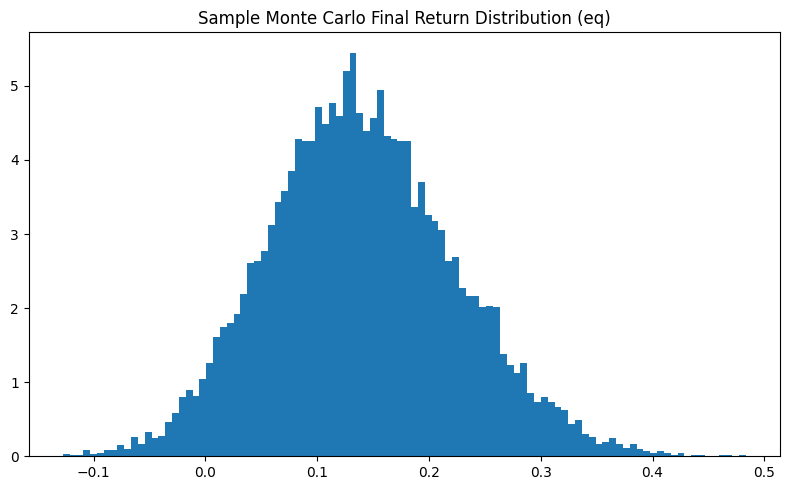

Saved sample MC distribution to resources/results/sample_mc_distribution_eq.pdf


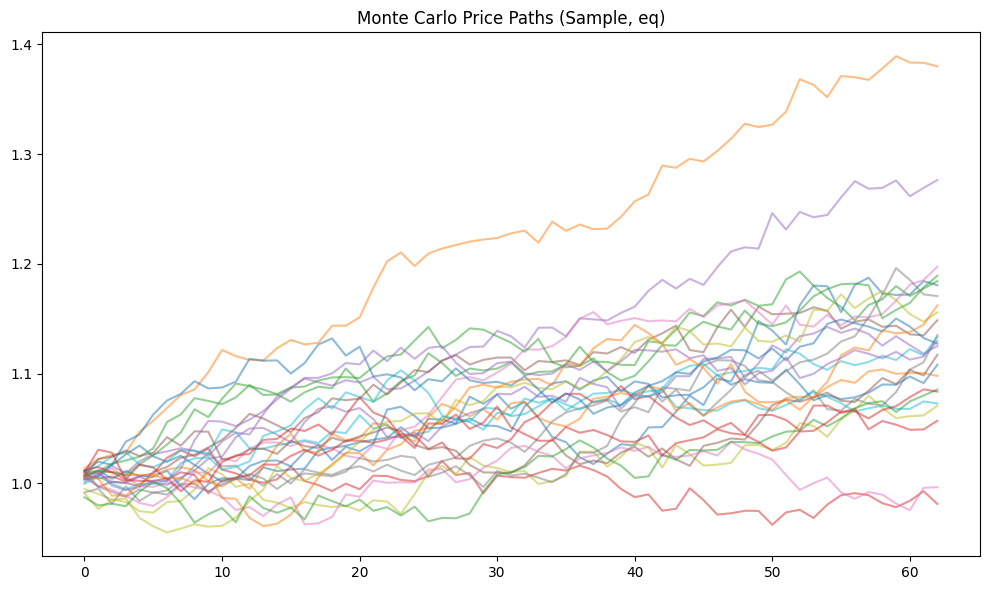

Saved sample MC paths to resources/results/mc_paths_eq.pdf
Running MV-Hist backtest
[WARN] Skipping 2021-01-04 — insufficient μ/Σ


AttributeError: module 'cvxpy' has no attribute 'promote'

In [10]:
port_eq,   w_eq,   mc_eq   = backtest_equal_weight(
    prices, sp500_df,
    start_date=BACKTEST_START,
    end_date=BACKTEST_END
)

port_hist, w_hist, mc_hist = backtest_mv_hist(
    prices, sp500_df,
    start_date=BACKTEST_START,
    end_date=BACKTEST_END
)

port_ml,   w_ml,   mc_ml   = backtest_mv_ml(
    prices, sp500_df,
    features_all,
    best_ml_model,
    start_date=BACKTEST_START,
    end_date=BACKTEST_END
)


**Save results and basic performance stats:**
Write portfolio paths, Monte Carlo summaries, and weights to disk. Then compute returns/volatility/Sharpe/drawdown and plot the combined equity curves.

In [ ]:
# Save portfolio time series
port_eq.to_csv(os.path.join(OUT_RESULTS_DIR, "port_eq.csv"))
port_hist.to_csv(os.path.join(OUT_RESULTS_DIR, "port_mv_hist.csv"))
port_ml.to_csv(os.path.join(OUT_RESULTS_DIR, "port_mv_ml.csv"))

# Save Monte Carlo summaries
mc_eq.to_csv(os.path.join(OUT_RESULTS_DIR, "mc_eq_summary.csv"))
mc_hist.to_csv(os.path.join(OUT_RESULTS_DIR, "mc_mv_hist_summary.csv"))
mc_ml.to_csv(os.path.join(OUT_RESULTS_DIR, "mc_mv_ml_summary.csv"))

# Save weight histories (full objects) as pickles
with open(os.path.join(OUT_RESULTS_DIR, "weights_eq.pkl"), "wb") as f:
    pickle.dump(w_eq, f)
with open(os.path.join(OUT_RESULTS_DIR, "weights_mv_hist.pkl"), "wb") as f:
    pickle.dump(w_hist, f)
with open(os.path.join(OUT_RESULTS_DIR, "weights_mv_ml.pkl"), "wb") as f:
    pickle.dump(w_ml, f)

def compute_stats(port_val, freq=252):
    """
    Compute some basic performance stats from a portfolio value series.
    """
    v = port_val["portfolio"]
    rets = np.log(v / v.shift(1)).dropna()
    total_ret = v.iloc[-1] - 1
    ann_ret = rets.mean() * freq
    ann_vol = rets.std() * np.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cummax = v.cummax()
    dd = (v - cummax) / cummax
    mdd = dd.min()
    return {
        "Total Return": float(total_ret),
        "Ann. Return": float(ann_ret),
        "Ann. Vol": float(ann_vol),
        "Sharpe": float(sharpe),
        "Max Drawdown": float(mdd),
    }

stats_eq   = compute_stats(port_eq)
stats_hist = compute_stats(port_hist)
stats_ml   = compute_stats(port_ml)

print("Equal Weight:", stats_eq)
print("MV-Hist    :", stats_hist)
print("MV-ML      :", stats_ml)

# Plot the three equity curves together
df_plot = pd.concat([
    port_eq["portfolio"].rename("Equal Weight"),
    port_hist["portfolio"].rename("MV-Hist"),
    port_ml["portfolio"].rename("MV-ML"),
], axis=1)

plt.figure(figsize=(12, 6))
df_plot.plot(ax=plt.gca(), title="Portfolio Value Over Time")
plt.ylabel("Portfolio Value")
plt.tight_layout()
eq_curve_path = os.path.join(OUT_RESULTS_DIR, "portfolio_equity_curves.pdf")
plt.savefig(eq_curve_path)
plt.show()
print("Saved equity curves to", eq_curve_path)

# Save stats as a small table
stats_df = pd.DataFrame({
    "Equal_Weight": stats_eq,
    "MV_Hist": stats_hist,
    "MV_ML": stats_ml
})
stats_df.to_csv(os.path.join(OUT_RESULTS_DIR, "strategy_stats.csv"))
print("\nSaved stats to:", os.path.join(OUT_RESULTS_DIR, "strategy_stats.csv"))


**Visualizations:**
Plot how the top holdings evolve over time and what the final rebalance portfolio looks like for each strategy.

In [ ]:
plot_top_holdings(w_eq,   "Equal_Weight", OUT_RESULTS_DIR, top_n=15)
plot_final_weights(w_eq,  "Equal_Weight", OUT_RESULTS_DIR, top_n=20)

plot_top_holdings(w_hist, "MV_Hist", OUT_RESULTS_DIR, top_n=15)
plot_final_weights(w_hist,"MV_Hist", OUT_RESULTS_DIR, top_n=20)

plot_top_holdings(w_ml,   "MV_ML", OUT_RESULTS_DIR, top_n=15)
plot_final_weights(w_ml,  "MV_ML", OUT_RESULTS_DIR, top_n=20)

print("\nAll outputs saved under:", OUT_RESULTS_DIR)
